# Large stretch
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/large_stretch.ipynb)

We compare different material models for uni-axial strain with a large stretch of up to five times its original length.

In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import numpy as np

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import (
    IsotropicElasticity3D,
    IsotropicHencky3D,
    NeoHookean3D,
)

torch.set_default_dtype(torch.float64)

# Material
E = 1000.0
nu = 0.3
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
K = lbd + 2.0 / 3.0 * mu
C10 = mu / 2
D1 = 2 / K


# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

# Boundary sets
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
center1 = nodes[:, 1] == 0.5
center2 = nodes[:, 2] == 0.5

# Load
U = 4.0
N = 21
displacements = torch.zeros_like(nodes)
displacements[right, 0] = U
increments = torch.linspace(0.0, 1.0, N)

# Boundary conditions
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, 0] = True
constraints[right, 0] = True
constraints[center1, 1] = True
constraints[center2, 2] = True

# Analytical stretch solution
λ = torch.linspace(1.0, 1.0 + U, N)

## Linear elasticity with small strains

In [2]:
# Reference solution
σ1_ref = torch.linspace(0.0, E * U, N)

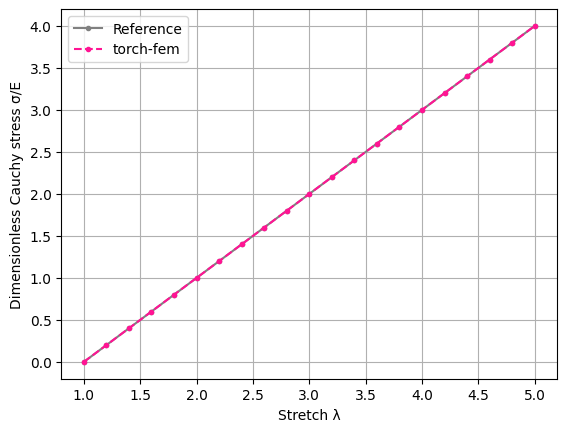

In [3]:
# Create model
material = IsotropicElasticity3D(E=E, nu=nu)
box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u1, f1, σ1, F1, α1 = box.solve(increments=increments, return_intermediate=True)

# Plot
plt.plot(λ, σ1_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ1[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Hencky material

In [4]:
# Reference solution
σ2_ref = torch.log(λ) * E

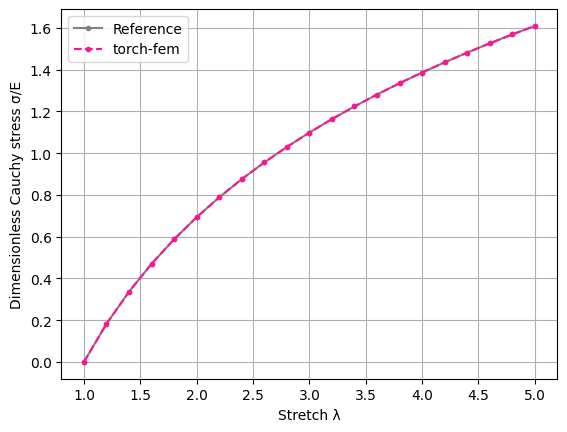

In [5]:
# Create model
material = IsotropicHencky3D(E=E, nu=nu)
box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u2, f2, σ2, F2, α2 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True
)

plt.plot(λ, σ2_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ2[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Neo-Hookean material

The strain energy potential is given as
$$
\psi = G \left(\textrm{tr}(\bar{B})-3\right) + \frac{1}{D} (J-1)^2
$$
with parameters $G$ (same as C10 in Abaqus or $2\mu_0$) and $D$ (same as D1 in Abaqus or $2K_0$). 

The kinematics are described via the deviatoric left Cauchy-Green tensor 
$$
    \bar{B} = \bar{F} \bar{F}^\top
$$
with the distrortion gradient (deviatoric part of the deformation gradient) 
$$
    \bar{F} = J ^{-\frac{1}{3}} F
$$
with the Jacobian
$$
     J = \textrm{det}(F).
$$

The Cauchy stress is computed as 
$$
    \sigma = \frac{2}{J} G \left( \bar{B}- \frac{1}{3} \textrm{tr}(\bar{B}) I\right) + \frac{2}{D}(J-1) I.
$$

The algorithmic tangent is given as 
$$
    \mathbb{C} = \frac{2}{J}G \left(\frac{1}{2}(\delta_{ik}\bar{B}_{jl}+\bar{B}_{ik}\delta_{jl}+\delta_{il}\bar{B}_{jk}+\bar{B}_{il}\delta_{jk}) -\frac{2}{3} (\delta_{ij}\bar{B}_{kl}+\bar{B}_{ij}\delta_{kl}) + \frac{2}{9} \delta_{ij}\delta_{kl} \bar{B}_{mm}\delta_{kl}\right) + \frac{2}{D}\left(2J-1 \right) \delta_{ij}\delta_{kl}
$$




See: 
- https://github.com/Sina-Taghizadeh/UMAT_Hyperelastic 
- Sun W, Chaikof EL, Levenston ME. Numerical approximation of tangent moduli for finite element implementations of nonlinear hyperelastic material models. J Biomech Eng. 2008 Dec;130(6):061003. doi: 10.1115/1.2979872. PMID: 19045532; PMCID: PMC2724673.


In [6]:
# Reference solution
J = torch.tensor(
    fsolve(
        lambda J: 2
        * C10
        / J
        * (J / λ.numpy() - (2 * J / λ.numpy() + λ.numpy() ** 2) / 3)
        / (J ** (2 / 3))
        + 2 / D1 * (J - 1),
        x0=np.ones(λ.shape),
    )
)

σ3_ref = 2 * C10 / J * (λ**2 - (λ**2 + 2 * J / λ) / 3) / (J ** (2 / 3)) + 2 / D1 * (
    J - 1
)

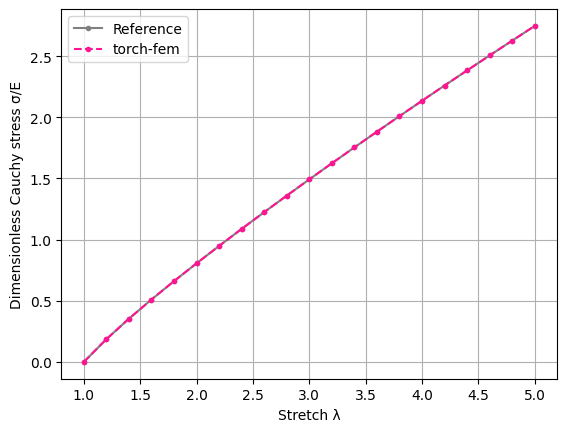

In [7]:
# Create model
material = NeoHookean3D(G=C10, D=D1)

box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u3, f3, σ3, F3, α3 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True
)

plt.plot(λ, σ3_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ3[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

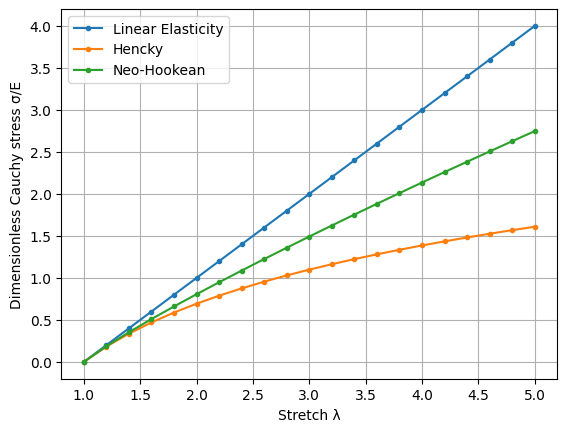

In [8]:
plt.plot(
    F1[..., 0, 0].mean(dim=1),
    σ1[..., 0, 0].mean(dim=1) / E,
    ".-",
    label="Linear Elasticity",
)
plt.plot(
    F2[..., 0, 0].mean(dim=1),
    σ2[..., 0, 0].mean(dim=1) / E,
    ".-",
    label="Hencky",
)
plt.plot(
    F3[..., 0, 0].mean(dim=1),
    σ3[..., 0, 0].mean(dim=1) / E,
    ".-",
    label="Neo-Hookean",
)
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()